# Learning Environment Transition Function

The objective of this project is to see if using specialized models for physical settings and incorporating domain knowledge can help improve the learning efficiency

<Axes: >

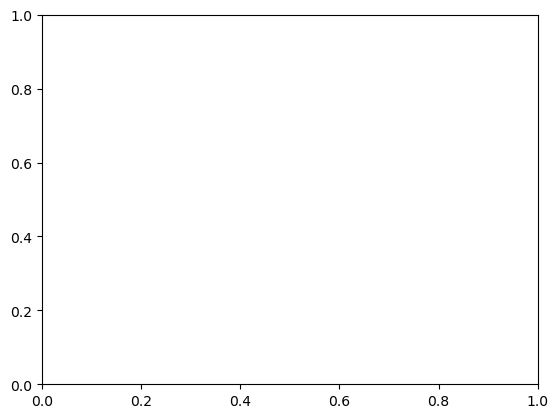

In [1]:
import matplotlib.pyplot as plt
plt.subplot()

In [2]:
import gym
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
import stable_baselines3
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.ppo import MlpPolicy
from stable_baselines3.common.evaluation import evaluate_policy

In [4]:
import torch.optim as optim

# Image datasets and image manipulation
import torchvision
import torchvision.transforms as transforms

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter

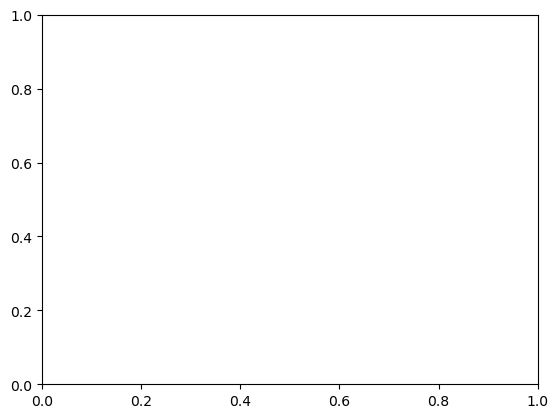

In [5]:
from models.SINDy import ureca_SINDy
from models.MLP import ureca_MLP
from models.PINN import ureca_PINN
from models.KAN import ureca_KAN

## Loading Lunar Lander Train and Test environment

In [6]:
env_name = 'CartPole-v1'

# Load the Lunar Lander environment for training
train_env = gym.make(env_name)

# Load the Lunar Lander environment for testing
test_env = gym.make(env_name)

print("Training and testing environments loaded successfully.")

Training and testing environments loaded successfully.


## Sample Episode and Create Transition Dataset

**TODO**

Check the following dataset generation process. Think about why we are generating this data? What does this tuple (state, action, next_state) mean?
We want to train a NN model which predicts next_state given the input state and action.

In [7]:
hyperparameters = {
    'policy': 'MlpPolicy',
    'batch_size': 64,
    'ent_coef': 0.005,
    'gae_lambda': 0.98,
    'gamma': 0.999,
    'n_epochs': 4,
    'n_steps': 20000,
    'n_timesteps': 100000,
    'normalize': False,  # If True, normalizes observations
    'n_envs': 16
}

log_dir = "./poster/"

In [ ]:
model_free_model = PPO(
                    policy=hyperparameters['policy'],
                    env=train_env,
                    batch_size=hyperparameters['batch_size'],
                    ent_coef=hyperparameters['ent_coef'],
                    gae_lambda=hyperparameters['gae_lambda'],
                    gamma=hyperparameters['gamma'],
                    n_epochs=hyperparameters['n_epochs'],
                    n_steps=hyperparameters['n_steps'],
                    verbose=1,
                    tensorboard_log=log_dir
                  )

model_free_model.learn(total_timesteps = hyperparameters['n_timesteps'])

In [30]:
def sample_transition_data_learned(model, env, num_eps = 1000, deterministic = True, maximum_samples = 150000):
    data = {
        "state" : [],
        "action" : [],
        "next_state" : [],
        "reward" : [],
        "done" : [],
    }
    for episode in range(num_eps):
        if episode % 10 == 0:
            print(f"\rSampling data from episode {episode}/{num_eps}",end='',flush=True)
        state = env.reset()
        if type(state) is tuple:
            state = state[0]
        done = False
        truncated = False
        while not done and not truncated:
            action, _states = model.predict(state, deterministic=deterministic)
            next_step = env.step(action)
            if len(next_step) == 4:
                next_state, reward, done, info = next_step
            else:
                next_state, reward, done, info, truncated = next_step
            if not done:
                doneType = 0
            else:
                doneType = 1
            data["state"].append(state)
            data["action"].append(int(action))
            data["next_state"].append(next_state)
            data["reward"].append(reward)
            data["done"].append(doneType)
            state = next_state
            if len(data["state"]) > maximum_samples:
                break
        if len(data["state"]) > maximum_samples:
            break
    print(f"Sampling data from episode {episode+1}/{num_eps}",end='',flush=True)
    return data

In [31]:
# Function to sample state-action-state pairs
def sample_transition_data(env, num_episodes=1000, maximum_samples = 150000):
    data = {
        "state" : [],
        "action" : [],
        "next_state" : [],
        "reward" : [],
        "done" : [],
    }
    for episode in range(num_episodes):
        if episode % 1000 == 0:
            print(f"\rSampling data from episode {episode}/{num_episodes}",end='',flush=True)
        state = env.reset()
        if type(state) is tuple:
            state = state[0]
        done = False
        truncated = False
        while not done and not truncated:
            action = env.action_space.sample()
            next_step = env.step(action)
            if len(next_step) == 4:
                next_state, reward, done, info = next_step
            else:
                next_state, reward, done, info, truncated = next_step
            if not done:
                doneType = 0
            else:
                doneType = 1
            data["state"].append(state)
            data["action"].append(int(action))
            data["next_state"].append(next_state)
            data["reward"].append(reward)
            data["done"].append(doneType)
            state = next_state
            if len(data["state"]) > maximum_samples:
                break
        if len(data["state"]) > maximum_samples:
            break
    print(f"Sampling data from episode {episode+1}/{num_episodes}",end='',flush=True)
        
    return data

In [ ]:
import pickle
import os
data = sample_transition_data(train_env,25000)

data_path = f'./dataset/raw_data_{env_name}.pkl'
os.makedirs(os.path.dirname(data_path), exist_ok=True)
with open(data_path,'wb') as f:
    pickle.dump(data,f)

In [9]:
import pickle
data_path = f'./dataset/raw_data_{env_name}.pkl'
with open(data_path,'rb') as f:
    data = pickle.load(f)

In [11]:
"""
Class input:
data (dct): {state : list of vector (np array) denoting the state of the environment
             action : list of vector (np array) denoting the action taken at each time step
             next_state : the next state after acting on the state
             reward : reward given by the environment
             done : is termination state or not
             }
"""
from models.SINDy import ureca_SINDy

SINDy_model = ureca_SINDy(data)

In [12]:
"""
Method input:
optimizer : PySindy optimizer, default : ps.STLSQ(threshold = 0.02)
feature_library : PySindy feature library, used by either initiate a PySindy feature library type or list of lambda functions, default PolynomialLibrary
differentiation_method
t_default : Time step in the dataset, by default the time-difference between each state is 1. Input can be the list of time slots the state was captured
discrete_time
feature_names
"""
SINDy_model.train_transition_model()

Data loaded successfully (1/4)
Data processed successfully (2/4)
Model created successfully (3/4)
(x0)[k+1] = 1.000 x0[k] + 0.020 x1[k]
(x1)[k+1] = -0.195 1 + 1.001 x1[k] + 0.195 u0[k] + 0.195 u0[k]^2
(x2)[k+1] = 1.000 x2[k] + 0.020 x3[k]
(x3)[k+1] = 0.292 1 + 0.313 x2[k] + 1.000 x3[k] + -0.292 u0[k] + -0.292 u0[k]^2
Model fitted successfully (4/4)


In [13]:
sindy_env = SINDy_model.create_surrogate_env()
print(type(sindy_env))
sindy_env.model.print()

[-0.0442256  -0.00078823 -0.0167803  -0.0366256 ]
<class 'models.SINDy.SindyMBRL'>
(x0)[k+1] = 1.000 x0[k] + 0.020 x1[k]
(x1)[k+1] = -0.195 1 + 1.001 x1[k] + 0.195 u0[k] + 0.195 u0[k]^2
(x2)[k+1] = 1.000 x2[k] + 0.020 x3[k]
(x3)[k+1] = 0.292 1 + 0.313 x2[k] + 1.000 x3[k] + -0.292 u0[k] + -0.292 u0[k]^2


In [50]:
from models.MLP import ureca_MLP

MLP_model = ureca_MLP(data, hidden_sizes = [25,25])

<bound method Module.parameters of Sequential(
  (0): Linear(in_features=5, out_features=25, bias=True)
  (1): ReLU()
  (2): Linear(in_features=25, out_features=25, bias=True)
  (3): ReLU()
  (4): Linear(in_features=25, out_features=4, bias=True)
)>
version: 1.14


epoch: 1190/1200  loss: 8.037281077122316e-057

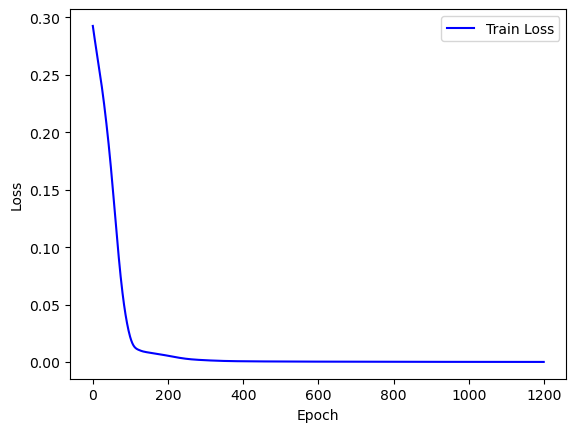

In [51]:
MLP_model.train_transition_model(epochs = 1200)

In [11]:
from models.PINN import ureca_PINN

PINN_model = ureca_PINN(data, hidden_sizes = [25,25])

<bound method Module.parameters of Sequential(
  (0): Linear(in_features=5, out_features=25, bias=True)
  (1): ReLU()
  (2): Linear(in_features=25, out_features=25, bias=True)
  (3): ReLU()
  (4): Linear(in_features=25, out_features=4, bias=True)
)>


In [32]:
def physics_loss(state, action, pred_next_state, dt=0.02, gravity = 9.8, cart_mass = 1, pole_mass = 0.1, length = 0.5, force_magnitude = 10):
    x, theta = state[:,:1], state[:,2:3]
    
    # Current and next velocities
    dx, dtheta = state[:, 1:2], state[:, 3:4]
    dx_next, dtheta_next = pred_next_state[:, 1:2], pred_next_state[:, 3:4]

    # Compute approximate accelerations
    ddx = (dx_next - dx) / dt
    ddtheta = (dtheta_next - dtheta) / dt

    # Human knowledge on CartPole's physics
    force = (2 * action.float() - 1) * force_magnitude
    total_mass = cart_mass + pole_mass
    polemass_length = pole_mass * length
    sintheta = torch.sin(theta)
    costheta = torch.cos(theta)

    temp = (force + polemass_length * dtheta ** 2 * sintheta) / total_mass
    thetaacc = (gravity * sintheta - costheta * temp) / (length * (4.0 / 3.0 - pole_mass * costheta ** 2 / total_mass)) #Newton's second law on rotation
    xacc = temp - polemass_length * thetaacc * costheta / total_mass #Newton's second law on linear motions

    return ((ddx - xacc) ** 2).mean() + ((ddtheta-thetaacc) ** 2).mean()

epoch: 1190/1200  loss: 0.5001674890518188

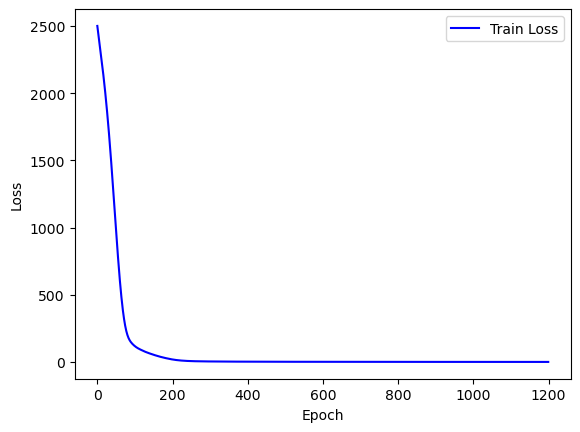

In [20]:
PINN_model.train_transition_model(physics_loss_fn = physics_loss, epochs = 1200, physics_loss_weight = 1)

In [22]:
pinn_env = PINN_model.create_surrogate_env()

[-0.000536   -0.00610614  0.00364228  0.01336626]


In [41]:
mlp_env = MLP_model.create_surrogate_env()

[ 0.0309883  -0.04040819 -0.03406153  0.01890027]


In [60]:
data = sample_transition_data(train_env, num_episodes = 1)
print('\n', len(data))

Sampling data from episode 1/1
 5


In [61]:
KAN_model = ureca_KAN(data, hidden_sizes = [5,5])

<class 'kan.MultKAN.MultKAN'>
checkpoint directory created: ./model
saving model version 0.0
MultKAN(
  (act_fun): ModuleList(
    (0-2): 3 x KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
  (symbolic_fun): ModuleList(
    (0-2): 3 x Symbolic_KANLayer()
  )
)


In [62]:
KAN_model.train_transition_model(epochs = 5)

Dataset processed (1/2)


| train_loss: 9.61e-02 | test_loss: 1.09e-01 | reg: 1.27e+01 | : 100%|█| 5/5 [00:04<00:00,  1.21it/s

saving model version 0.1
Model fitted (2/2)


### Efforts in trying to optimize KAN

In [63]:
KAN_model.refine_transition_model(epochs=2)

| train_loss: 8.49e-02 | test_loss: 9.81e-02 | reg: 1.76e+01 | : 100%|█| 2/2 [00:01<00:00,  1.30it/s


saving model version 0.2
Pruning model (1/3)
<class 'kan.MultKAN.MultKAN'>
saving model version 0.3
Refining model (2/3)


| train_loss: 7.26e-02 | test_loss: 8.54e-02 | reg: 1.96e+01 | : 100%|█| 2/2 [00:01<00:00,  1.31it/s


saving model version 0.4
fixing (0,0,0) with x, r2=0.9605478048324585, c=1
fixing (0,0,1) with x, r2=0.5244148373603821, c=1
fixing (0,0,2) with x, r2=0.6729555726051331, c=1
fixing (0,0,3) with x, r2=0.7822318077087402, c=1
fixing (0,0,4) with x, r2=0.6828722953796387, c=1
fixing (0,1,0) with x^2, r2=0.9999353885650635, c=2
For (0,1,1) the best fit was x, but r^2 = 0.4725833535194397 and this is lower than 0.5. This edge was omitted, keep training or try a different threshold.
fixing (0,1,2) with x, r2=0.6782045960426331, c=1
fixing (0,1,3) with x, r2=0.6946297287940979, c=1
For (0,1,4) the best fit was x, but r^2 = 0.051414359360933304 and this is lower than 0.5. This edge was omitted, keep training or try a different threshold.
fixing (0,2,0) with x, r2=0.7807365655899048, c=1
fixing (0,2,1) with x, r2=0.827724814414978, c=1
fixing (0,2,2) with x, r2=0.6754540205001831, c=1
For (0,2,3) the best fit was x, but r^2 = 5.459187832457246e-06 and this is lower than 0.5. This edge was omit

| train_loss: 9.92e-02 | test_loss: 9.42e-02 | reg: 4.78e+00 | : 100%|█| 2/2 [00:04<00:00,  2.46s/it

saving model version 0.6


In [64]:
from kan.utils import ex_round

ex_round(KAN_model.model.symbolic_formula()[0][0],4)

0.004*x_1 - 0.0025*x_3 - 0.0059*x_4 + 0.0068*x_5 + 0.0094*(-0.4764*x_2 - 1)**2 + 0.0421*(-0.0065*x_1 - 0.0111*(0.302 - x_2)**2 - 0.0752*(-x_3 - 0.02)**2 - 0.0017*(-x_4 - 0.16)**2 - 0.0084*(-0.8894*x_5 - 1)**2 + 1)**2 - 0.1119*(-0.0061*x_1 + 0.0185*x_3 + 0.0046*x_4 + 0.0071*(-0.16*x_2 - 1)**2 + 0.0005*(0.9997*x_5 + 1)**2 + 1)**2 + 0.5707*(0.0061*x_1 - 0.0185*x_3 - 0.0046*x_4 - 0.0071*(-0.16*x_2 - 1)**2 - 0.0005*(0.9997*x_5 + 1)**2 - 1)**2 + 0.0196*(0.0066*x_1 - 0.0026*x_2 - 0.0123*x_3 + 0.003*x_4 + 0.0461*x_5 + 1)**2 + 0.0489*(0.0082*x_1 + 0.0088*x_2 + 0.0085*x_4 + 0.1875*(-x_3 - 0.02)**2 + 0.0072*(-0.997*x_5 - 1)**2 + 1)**2 - 1.4196*(0.018*x_1 - 0.0112*x_3 - 0.0263*x_4 + 0.0303*x_5 + 0.0421*(-0.4764*x_2 - 1)**2 - 1)**2 + 4.2294*(-0.0026*(-0.0066*x_1 + 0.0026*x_2 + 0.0123*x_3 - 0.003*x_4 - 0.0461*x_5 - 1)**2 - 0.0362*(-0.0065*x_1 - 0.0111*(0.302 - x_2)**2 - 0.0752*(-x_3 - 0.02)**2 - 0.0017*(-x_4 - 0.16)**2 - 0.0084*(-0.8894*x_5 - 1)**2 + 1)**2 + 0.1854*(0.0061*x_1 - 0.0185*x_3 - 0.0046*

In [11]:
kan_env = KAN_model.create_surrogate_env()

[ 0.01572628  0.02485572 -0.02730412  0.01484243]


## Test the models on different number of trajectories taken from the real world

Report the results you get and the training/test plot. Put the results in the word file, you will reuse the reported results when writing the URECA report.

In [34]:
def evaluate(model, env, num_eps = 1000, deterministic = True):
    rewards = []
    for episode in range(num_eps):
        if episode >= 10 and episode % 100 == 0:
            print(f"Sampling data from episode {episode}")
            #print("Episode: ", episode, "Reward: ", rewards[episode-1])
        try:
            state, info = env.reset()
        except:
            state = env.reset()
        done = False
        truncated = False
        ep_reward = []
        while not done and not truncated:
            action, _states = model.predict(state, deterministic=deterministic)
            next_step = env.step(action)
            if len(next_step) == 4:
                next_state, reward, done, info = next_step
            else:
                next_state, reward, done, truncated, info = next_step
            ep_reward.append(reward)
            state = next_state
        rewards.append(sum(ep_reward))
    return sum(rewards)/len(rewards)

Sampling data from episode 1/1
 Total number of samples taken: 18
<class 'kan.MultKAN.MultKAN'>
checkpoint directory created: ./model
saving model version 0.0
MultKAN(
  (act_fun): ModuleList(
    (0-2): 3 x KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
  (symbolic_fun): ModuleList(
    (0-2): 3 x Symbolic_KANLayer()
  )
)
<bound method Module.parameters of Sequential(
  (0): Linear(in_features=5, out_features=25, bias=True)
  (1): ReLU()
  (2): Linear(in_features=25, out_features=25, bias=True)
  (3): ReLU()
  (4): Linear(in_features=25, out_features=4, bias=True)
)>
version: 1.14
<bound method Module.parameters of Sequential(
  (0): Linear(in_features=5, out_features=25, bias=True)
  (1): ReLU()
  (2): Linear(in_features=25, out_features=25, bias=True)
  (3): ReLU()
  (4): Linear(in_features=25, out_features=4, bias=True)
)>
epoch: 1190/1200  loss: 0.08052964508533478

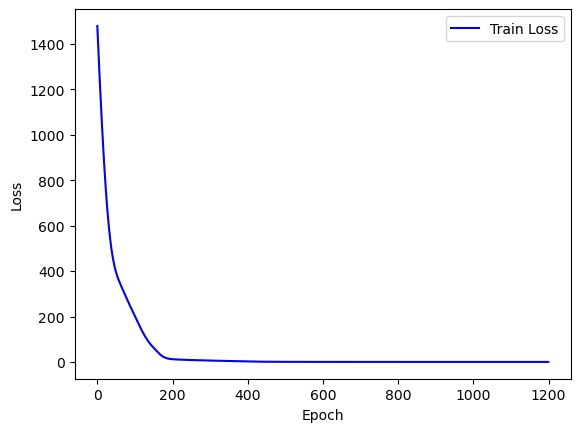

[-0.024629   -0.00292034 -0.01365416 -0.02670559]
[-0.01539255  0.00363309  0.04062933 -0.03113281]
[ 0.02135987 -0.02002056  0.03017297 -0.01225592]
[ 0.03514627 -0.03952262  0.04004687  0.00337304]
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
PINN RL
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24.3     |
|    ep_rew_mean     | 24.3     |
| time/              |          |
|    fps             | 522      |
|    iterations      | 1        |
|    time_elapsed    | 38       |
|    total_timesteps | 20000    |
---------------------------------
PINN RL's current reward: 9.45
Data: 1, total time: 20000, PINN RL's current

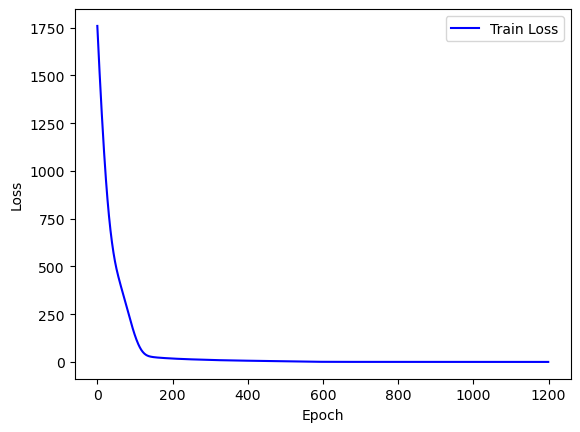

[ 0.03020349 -0.02836778  0.04110214 -0.02629456]
[ 0.03853865  0.0419213  -0.01911356  0.04809805]
[ 0.0009616  -0.00982426  0.00985658  0.00523026]
[0.0172398  0.02967235 0.01484144 0.01632766]
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
PINN RL
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 31       |
|    ep_rew_mean     | 31       |
| time/              |          |
|    fps             | 529      |
|    iterations      | 1        |
|    time_elapsed    | 37       |
|    total_timesteps | 20000    |
---------------------------------
PINN RL's current reward: 9.35
Data: 2, total time: 20000, PINN RL's current rew

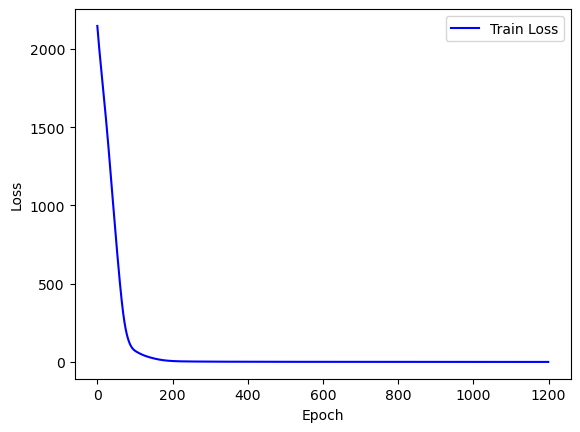

[-0.02305989 -0.0077826   0.03334423 -0.01308583]
[-0.04944551  0.00266212  0.03321088 -0.02667568]
[ 0.03377168 -0.00226028 -0.04064877 -0.00869938]
[ 0.03832538  0.01648953  0.01786753 -0.03225137]
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
PINN RL
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 26.7     |
|    ep_rew_mean     | 26.7     |
| time/              |          |
|    fps             | 545      |
|    iterations      | 1        |
|    time_elapsed    | 36       |
|    total_timesteps | 20000    |
---------------------------------
PINN RL's current reward: 80.85
Data: 5, total time: 20000, PINN RL's curren

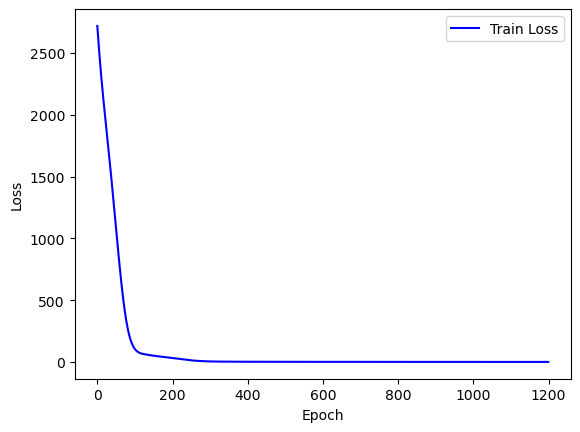

[ 0.02482044 -0.01781604  0.04624813  0.01179216]
[-0.03631311  0.04243655 -0.02280874 -0.00726178]
[ 0.01461479  0.01974119 -0.03169514  0.02374585]
[ 0.03081597  0.0442737  -0.01369986 -0.04042025]
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
PINN RL
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24.3     |
|    ep_rew_mean     | 24.3     |
| time/              |          |
|    fps             | 568      |
|    iterations      | 1        |
|    time_elapsed    | 35       |
|    total_timesteps | 20000    |
---------------------------------
PINN RL's current reward: 228.65
Data: 10, total time: 20000, PINN RL's curr

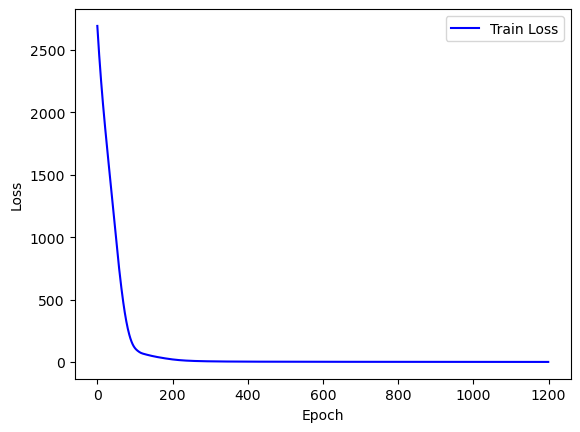

[ 0.02956612  0.03525904  0.04505431 -0.00564251]
[ 0.00598607 -0.0104904  -0.04151344 -0.03282974]
[-0.0265027  -0.04736426  0.0227524  -0.04803229]
[0.03215114 0.03391872 0.02030303 0.00630541]
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
PINN RL
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 31.1     |
|    ep_rew_mean     | 31.1     |
| time/              |          |
|    fps             | 594      |
|    iterations      | 1        |
|    time_elapsed    | 33       |
|    total_timesteps | 20000    |
---------------------------------
PINN RL's current reward: 135.75
Data: 25, total time: 20000, PINN RL's current 

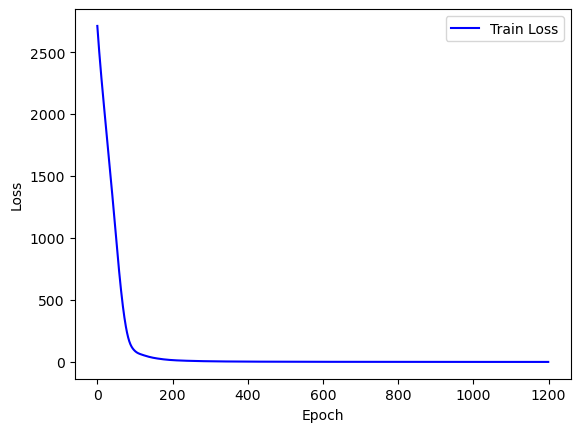

[-0.00679344 -0.0247482  -0.02940324  0.0280696 ]
[0.01328801 0.00413484 0.02558856 0.01888619]
[-0.03333753  0.03747593 -0.00013616  0.02508365]
[-0.04807366  0.03937311 -0.02786303  0.01428917]
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
PINN RL
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21       |
|    ep_rew_mean     | 21       |
| time/              |          |
|    fps             | 624      |
|    iterations      | 1        |
|    time_elapsed    | 32       |
|    total_timesteps | 20000    |
---------------------------------
PINN RL's current reward: 325.35
Data: 50, total time: 20000, PINN RL's current 

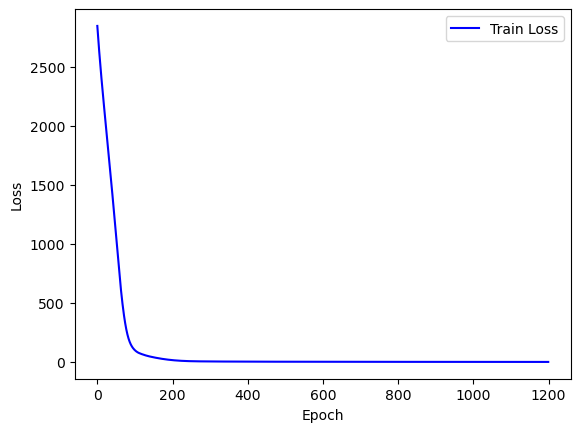

[ 0.01811998 -0.033899    0.03129624  0.0155158 ]
[0.03025036 0.04948896 0.0112011  0.04843137]
[ 0.0200095   0.02445695  0.0431013  -0.01588552]
[ 0.00363343  0.01546545 -0.00169793  0.01554037]
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
PINN RL
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 26.2     |
|    ep_rew_mean     | 26.2     |
| time/              |          |
|    fps             | 611      |
|    iterations      | 1        |
|    time_elapsed    | 32       |
|    total_timesteps | 20000    |
---------------------------------
PINN RL's current reward: 271.25
Data: 100, total time: 20000, PINN RL's current

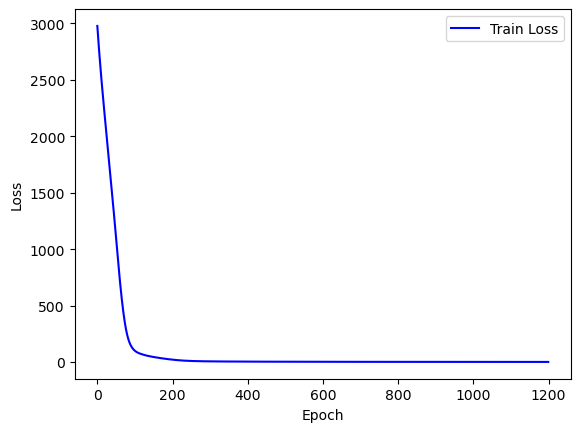

[-0.02032966  0.02263196 -0.03966238  0.0069775 ]
[ 0.04943074 -0.00493667  0.00696128  0.03604674]
[-0.0056328   0.04146768  0.02995972  0.00960178]
[ 0.02102745  0.00765317 -0.03169457  0.0031388 ]
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
PINN RL
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.7     |
|    ep_rew_mean     | 21.7     |
| time/              |          |
|    fps             | 599      |
|    iterations      | 1        |
|    time_elapsed    | 33       |
|    total_timesteps | 20000    |
---------------------------------
PINN RL's current reward: 309.6
Data: 250, total time: 20000, PINN RL's curr

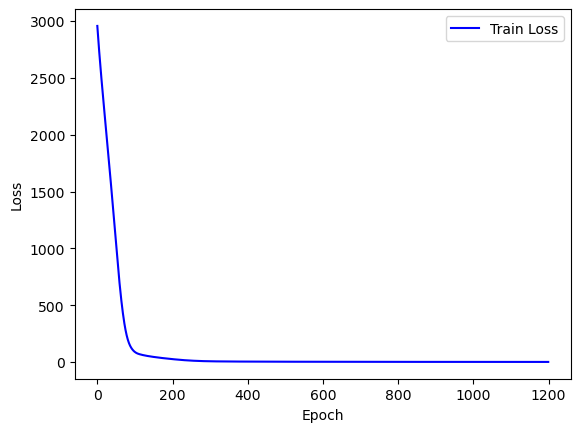

[-0.04762052  0.0387124  -0.01950462  0.03493756]
[ 0.03193038 -0.01436091 -0.01296391  0.02986867]
[-0.03917924 -0.02466826 -0.034794    0.02119396]
[-0.04679865  0.02624614  0.01854816  0.00410949]
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
PINN RL
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24.5     |
|    ep_rew_mean     | 24.5     |
| time/              |          |
|    fps             | 603      |
|    iterations      | 1        |
|    time_elapsed    | 33       |
|    total_timesteps | 20000    |
---------------------------------
PINN RL's current reward: 264.0
Data: 500, total time: 20000, PINN RL's curr

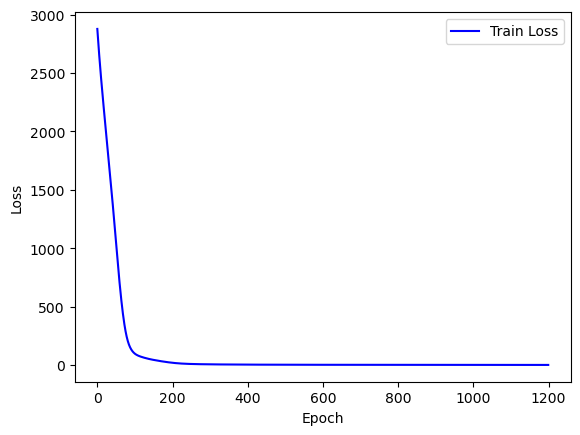

[ 0.04965056 -0.02079139 -0.01758877 -0.0145627 ]
[ 0.03001696 -0.00530786 -0.03044535  0.00845893]
[ 0.02894961  0.01158503  0.02633556 -0.04412962]
[ 0.01962224 -0.01987672  0.03452212 -0.02246886]
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
PINN RL
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 25.2     |
|    ep_rew_mean     | 25.2     |
| time/              |          |
|    fps             | 620      |
|    iterations      | 1        |
|    time_elapsed    | 32       |
|    total_timesteps | 20000    |
---------------------------------
PINN RL's current reward: 492.1
Data: 1000, total time: 20000, PINN RL's cur

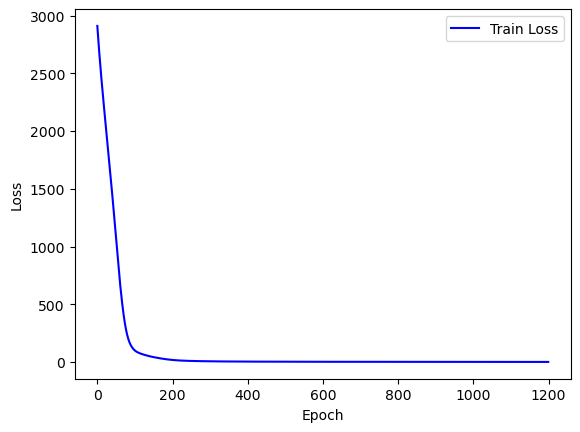

[-0.04609099  0.01925339 -0.04180214 -0.00459845]
[ 0.02150884  0.04825497 -0.00305176  0.00589526]
[-0.02564603 -0.02479782 -0.03174183  0.03832692]
[ 0.03758408  0.03822323 -0.04292525 -0.03881435]
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
PINN RL
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24.6     |
|    ep_rew_mean     | 24.6     |
| time/              |          |
|    fps             | 626      |
|    iterations      | 1        |
|    time_elapsed    | 31       |
|    total_timesteps | 20000    |
---------------------------------
PINN RL's current reward: 285.6
Data: 2500, total time: 20000, PINN RL's cur

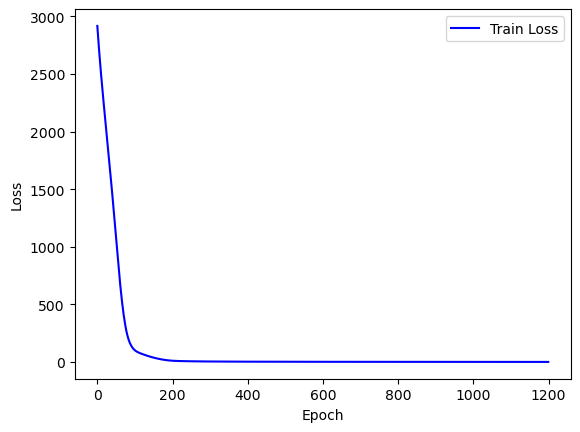

[0.01111264 0.01807671 0.00692828 0.02035647]
[ 0.04492977 -0.02963685  0.00817212  0.04388306]
[ 0.04771713 -0.04986897 -0.02193753  0.001198  ]
[ 0.00648    -0.0338806   0.02738938  0.01478876]
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
PINN RL
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 26       |
|    ep_rew_mean     | 26       |
| time/              |          |
|    fps             | 619      |
|    iterations      | 1        |
|    time_elapsed    | 32       |
|    total_timesteps | 20000    |
---------------------------------
PINN RL's current reward: 500.0
PINN RL maximum reward: 500.0


In [17]:
import json

maximum_rewards = [[],[]]
all_data = {}
for num_episode in [1,2,5,10,25,50,100,250,500,1000,2500,5000]:
    data = sample_transition_data(train_env, num_episode)
    print(f"\n Total number of samples taken: {len(data["state"])}")
    SINDy_model = ureca_SINDy(data)
    KAN_model = ureca_KAN(data, hidden_sizes = [25,25])
    MLP_model = ureca_MLP(data, hidden_sizes = [25,25])
    PINN_model = ureca_PINN(data, hidden_sizes = [25,25])
    PINN_model.train_transition_model(physics_loss_fn = physics_loss, epochs = 1200, physics_loss_weight = 1)
    #SINDy_model.train_transition_model()
    #KAN_model.train_transition_model(epochs = 50)
    #MLP_model.train_transition_model(epochs = 1500)
    sindy_env = SINDy_model.create_surrogate_env()
    kan_env = KAN_model.create_surrogate_env()
    mlp_env = MLP_model.create_surrogate_env()
    pinn_env = PINN_model.create_surrogate_env()
    sindy_rl_model = PPO(
        policy=hyperparameters['policy'],
        env=sindy_env,
        batch_size=hyperparameters['batch_size'],
        ent_coef=hyperparameters['ent_coef'],
        gae_lambda=hyperparameters['gae_lambda'],
        gamma=hyperparameters['gamma'],
        n_epochs=hyperparameters['n_epochs'],
        n_steps=hyperparameters['n_steps'],
        verbose=1,
        #tensorboard_log=log_dir
    )
    mlp_rl_model = PPO(
        policy=hyperparameters['policy'],
        env=mlp_env,
        batch_size=hyperparameters['batch_size'],
        ent_coef=hyperparameters['ent_coef'],
        gae_lambda=hyperparameters['gae_lambda'],
        gamma=hyperparameters['gamma'],
        n_epochs=hyperparameters['n_epochs'],
        n_steps=hyperparameters['n_steps'],
        verbose=1,
        #tensorboard_log=log_dir
        )
    kan_rl_model = PPO(
        policy=hyperparameters['policy'],
        env=kan_env,
        batch_size=hyperparameters['batch_size'],
        ent_coef=hyperparameters['ent_coef'],
        gae_lambda=hyperparameters['gae_lambda'],
        gamma=hyperparameters['gamma'],
        n_epochs=hyperparameters['n_epochs'],
        n_steps=hyperparameters['n_steps'],
        verbose=1,
        #tensorboard_log=log_dir
        )
    pinn_rl_model = PPO(
        policy=hyperparameters['policy'],
        env=pinn_env,
        batch_size=hyperparameters['batch_size'],
        ent_coef=hyperparameters['ent_coef'],
        gae_lambda=hyperparameters['gae_lambda'],
        gamma=hyperparameters['gamma'],
        n_epochs=hyperparameters['n_epochs'],
        n_steps=hyperparameters['n_steps'],
        verbose=1,
        #tensorboard_log=log_dir
        )
    time = 0
    time_step_interval = 20000
    max_time = 100000
    model_names = ['PINN RL']
    model_list = [pinn_rl_model]
    all_reward_lists = [[] for i in range(len(model_list))]
    all_times = [0]*len(model_list)
    reached_500 = [False]*len(model_list)
    
    while time < max_time:
        for i in range(len(model_list)):
            if reached_500[i] == True:
                continue
            print(model_names[i])
            model_list[i].learn(total_timesteps=time_step_interval)
            all_reward_lists[i].append(evaluate(model_list[i], test_env, num_eps = 20))
            print(f'{model_names[i]}\'s current reward: {all_reward_lists[i][-1]}')
            if not reached_500[i]:
                all_times[i] += time_step_interval
            if all_reward_lists[i][-1] == 500:
                reached_500[i] = True
        if False not in reached_500:
            break
        time += time_step_interval
        for i in range(len(model_list)):
            print(f'Data: {num_episode}, total time: {time}, {model_names[i]}\'s current reward: {all_reward_lists[i][-1]}')
        
    
    for i in range(len(model_list)):
        print(f'{model_names[i]} maximum reward: {max(all_reward_lists[i])}')
        maximum_rewards[i].append(max(all_reward_lists[i]))

    all_data[num_episode] = all_reward_lists

    with open(f'./results/checkpoints/result_all_data_kan_only_{num_episode}.json','w') as file:
        json.dump(all_data, file, indent=4)

## Test PINN and NN on the "good" trajectory by first training a model-free agent then train PINN and NN on the samples got from this good model-free agent

In [43]:
train_env = gym.make('CartPole-v1')

reward_list = []
# Your custom step list
steps = [x * 22 for x in [25, 50]]

# Initialize model with a fixed n_steps (not too small or too large)
model = PPO("MlpPolicy", train_env, n_steps=550, verbose=1)

# Train in chunks
previous = 0
for current in steps:
    delta = current - previous
    print(f"Training for {delta} steps (total so far: {current})")
    model.learn(total_timesteps=delta, reset_num_timesteps=False)
    reward_list.append(evaluate(model, test_env, num_eps = 20))
    print(reward_list[-1],"Current reward")
    previous = current

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Training for 550 steps (total so far: 550)
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.2     |
|    ep_rew_mean     | 19.2     |
| time/              |          |
|    fps             | 713      |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 550      |
---------------------------------
104.9 Current reward
Training for 550 steps (total so far: 1100)
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22.3     |
|    ep_rew_mean     | 22.3     |
| time/              |          |
|    fps             | 690      |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 1100     |
---------------------------------
96.6 Current reward


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22.6     |
|    ep_rew_mean     | 22.6     |
| time/              |          |
|    fps             | 568      |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 550      |
---------------------------------
Sampling data from episode 0/50Sampling data from episode 25/25Sampling data from episode 2/50<bound method Module.parameters of Sequential(
  (0): Linear(in_features=5, out_features=25, bias=True)
  (1): ReLU()
  (2): Linear(in_features=25, out_features=25, bias=True)
  (3): ReLU()
  (4): Linear(in_features=25, out_features=4, bias=True)
)>
version: 1.14
<bound method Module.parameters of Sequential(
  (0): Linear(in_features=5, out_features=25, bias=True)
  (1): ReLU()
  (2): Linear(in_features=25, out_features=25, bias=True)
  (3): ReLU()
  (4): Linear(in_f

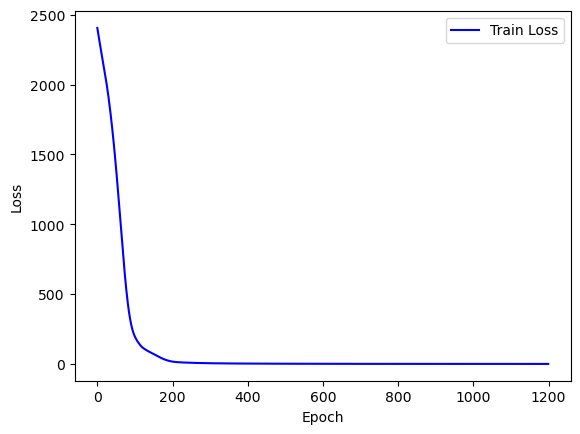

epoch: 1490/1500  loss: 0.00018395679944660515

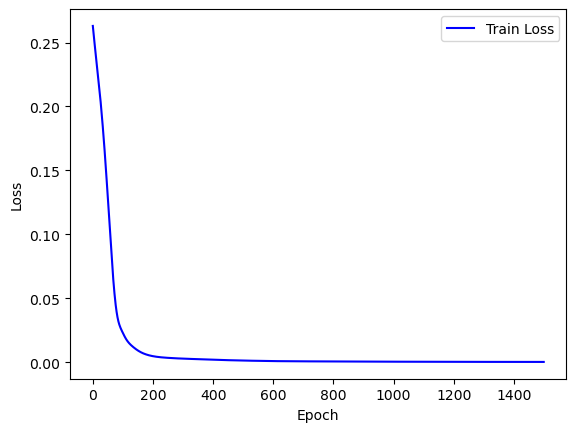

[-0.04356438 -0.03205935  0.03111275  0.04814593]
[-0.02590537  0.01970063  0.03853248  0.03243791]
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
PINN RL
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24.4     |
|    ep_rew_mean     | 24.4     |
| time/              |          |
|    fps             | 436      |
|    iterations      | 1        |
|    time_elapsed    | 45       |
|    total_timesteps | 20000    |
---------------------------------
PINN RL's current reward: 150.35
MLP RL
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23       |
|    ep_rew_mean     | 23       |
| time/              |          |
|    fps             | 439      |
|    iterations      | 1        |
|    time_elapsed    | 45       |
|    total_timesteps | 20000    |
------------------

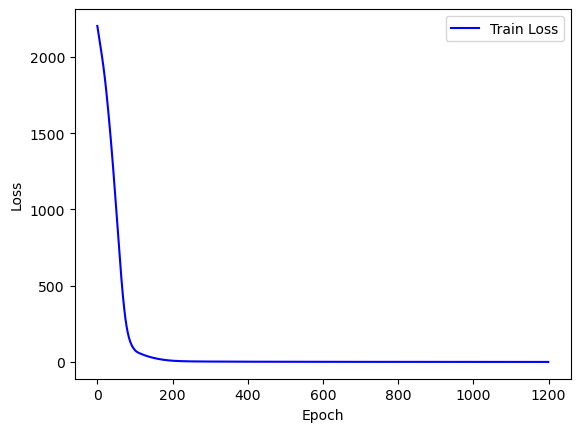

epoch: 1490/1500  loss: 4.1712359234225005e-05

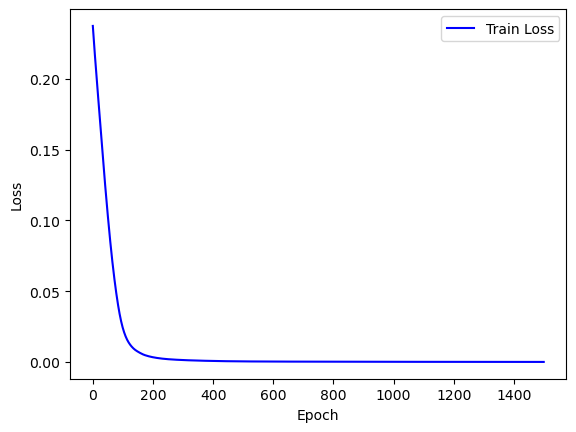

[-0.02537512  0.01542772  0.04216505 -0.04104827]
[ 0.03150852 -0.01465407  0.04531948  0.01060451]
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
PINN RL
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.1     |
|    ep_rew_mean     | 21.1     |
| time/              |          |
|    fps             | 453      |
|    iterations      | 1        |
|    time_elapsed    | 44       |
|    total_timesteps | 20000    |
---------------------------------
PINN RL's current reward: 59.95
MLP RL
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23.5     |
|    ep_rew_mean     | 23.5     |
| time/              |          |
|    fps             | 437      |
|    iterations      | 1        |
|    time_elapsed    | 45       |
|    total_timesteps | 20000    |
-------------------

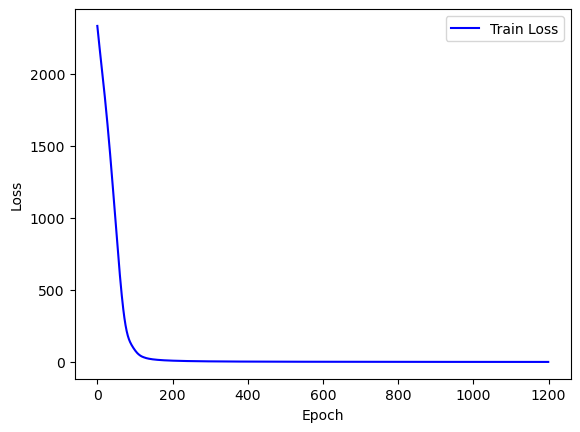

epoch: 1490/1500  loss: 4.5122415031073615e-05

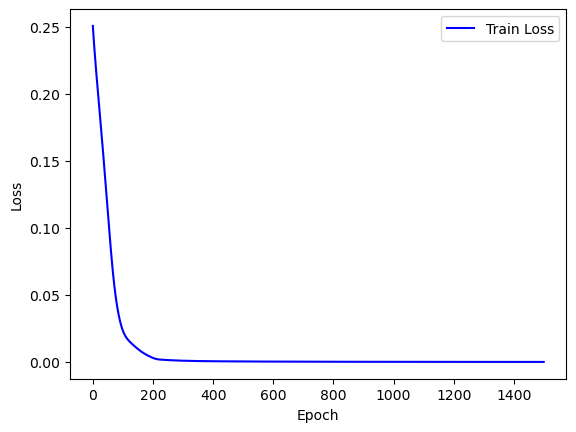

[ 0.04168291  0.04553427 -0.03927935  0.00229921]
[ 0.00930153 -0.01698408 -0.00967396  0.02012925]
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
PINN RL
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 26.1     |
|    ep_rew_mean     | 26.1     |
| time/              |          |
|    fps             | 439      |
|    iterations      | 1        |
|    time_elapsed    | 45       |
|    total_timesteps | 20000    |
---------------------------------
PINN RL's current reward: 116.3
MLP RL
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24.2     |
|    ep_rew_mean     | 24.2     |
| time/              |          |
|    fps             | 439      |
|    iterations      | 1        |
|    time_elapsed    | 45       |
|    total_timesteps | 20000    |
-------------------

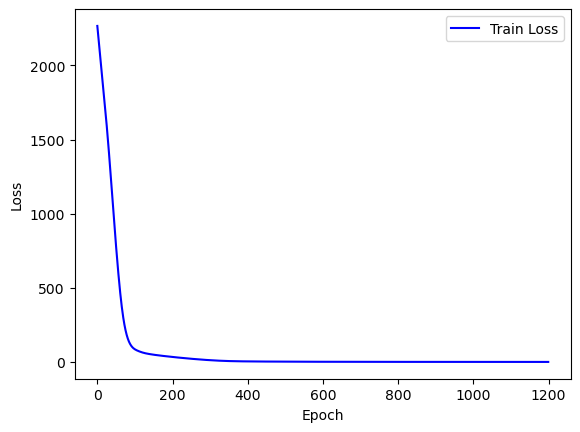

epoch: 1490/1500  loss: 7.183211710071191e-058

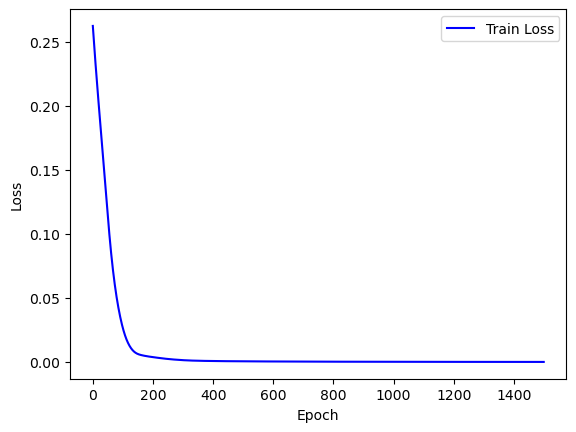

[-0.03808909  0.0364817   0.01241914  0.04584519]
[ 0.0396979   0.02423451 -0.0058528  -0.0353936 ]
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
PINN RL
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 28.3     |
|    ep_rew_mean     | 28.3     |
| time/              |          |
|    fps             | 435      |
|    iterations      | 1        |
|    time_elapsed    | 45       |
|    total_timesteps | 20000    |
---------------------------------
PINN RL's current reward: 251.45
MLP RL
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 26.6     |
|    ep_rew_mean     | 26.6     |
| time/              |          |
|    fps             | 433      |
|    iterations      | 1        |
|    time_elapsed    | 46       |
|    total_timesteps | 20000    |
------------------

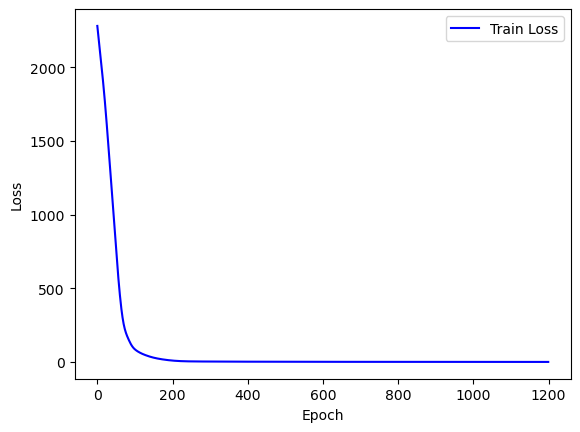

epoch: 1490/1500  loss: 5.408082506619394e-055

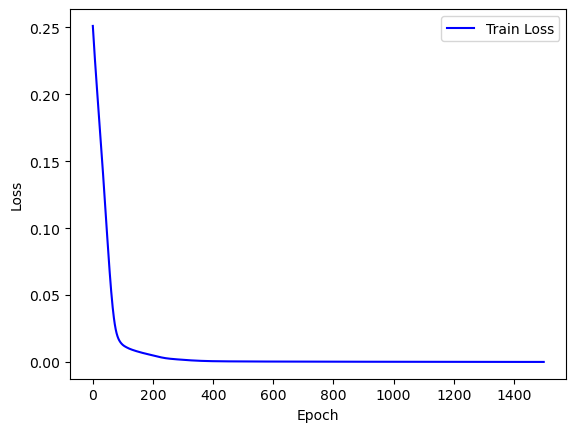

[-0.02443327 -0.04441306  0.01898853  0.01376655]
[-0.0476734  -0.01095803 -0.01379177  0.04708454]
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
PINN RL
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24.7     |
|    ep_rew_mean     | 24.7     |
| time/              |          |
|    fps             | 447      |
|    iterations      | 1        |
|    time_elapsed    | 44       |
|    total_timesteps | 20000    |
---------------------------------
PINN RL's current reward: 118.35
MLP RL
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.6     |
|    ep_rew_mean     | 21.6     |
| time/              |          |
|    fps             | 438      |
|    iterations      | 1        |
|    time_elapsed    | 45       |
|    total_timesteps | 20000    |
------------------

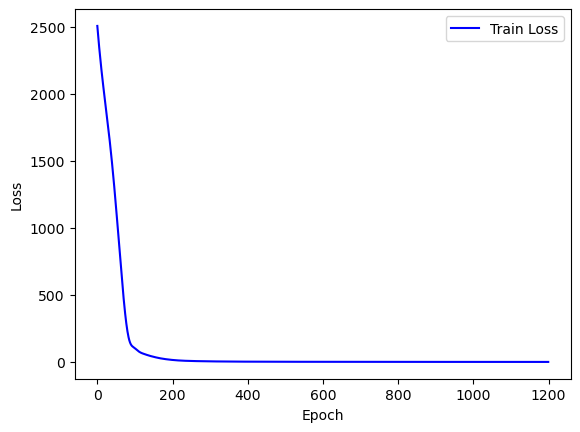

epoch: 1490/1500  loss: 8.864752453519031e-059

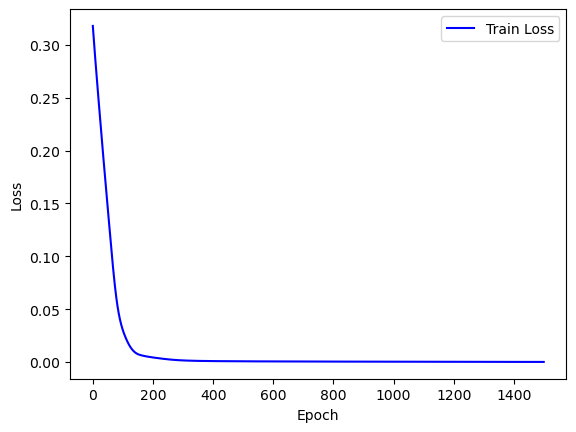

[-0.02234552  0.00652064 -0.00207489  0.03879745]
[-0.02860113  0.04958602 -0.03837721  0.04768451]
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
PINN RL
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 28.2     |
|    ep_rew_mean     | 28.2     |
| time/              |          |
|    fps             | 448      |
|    iterations      | 1        |
|    time_elapsed    | 44       |
|    total_timesteps | 20000    |
---------------------------------
PINN RL's current reward: 163.45
MLP RL
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.9     |
|    ep_rew_mean     | 20.9     |
| time/              |          |
|    fps             | 432      |
|    iterations      | 1        |
|    time_elapsed    | 46       |
|    total_timesteps | 20000    |
------------------

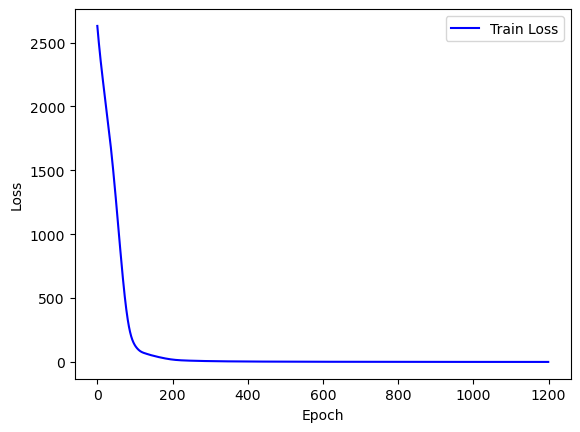

epoch: 1490/1500  loss: 0.00010476621537236497

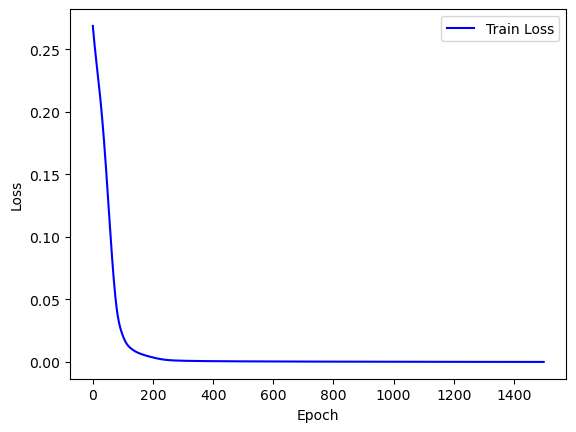

[-0.00670108 -0.02520757  0.02854221 -0.0264722 ]
[ 0.03873665  0.0187857   0.04021195 -0.020158  ]
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
PINN RL
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.2     |
|    ep_rew_mean     | 27.2     |
| time/              |          |
|    fps             | 579      |
|    iterations      | 1        |
|    time_elapsed    | 34       |
|    total_timesteps | 20000    |
---------------------------------
PINN RL's current reward: 158.35
MLP RL
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23.4     |
|    ep_rew_mean     | 23.4     |
| time/              |          |
|    fps             | 623      |
|    iterations      | 1        |
|    time_elapsed    | 32       |
|    total_timesteps | 20000    |
------------------

In [42]:
import json

all_data = {}
for num_episode in [50,100,250,500,1000,2500,5000]:
    train_env = gym.make('CartPole-v1')
    model_free = PPO("MlpPolicy", train_env, n_steps=550, verbose=1)
    model_free.learn(total_timesteps = int((num_episode*0.5*0.8*22)))
    data_random = sample_transition_data(train_env, int(num_episode*0.5))
    data_learned = sample_transition_data_learned(model = model_free, env = train_env, num_eps = num_episode, 
                                                  deterministic = True, maximum_samples = int(num_episode*0.5*0.2*22))
    for key in data_learned.keys():
        data_learned[key].extend(data_random[key])
    MLP_model = ureca_MLP(data_learned, hidden_sizes = [25,25])
    PINN_model = ureca_PINN(data_learned, hidden_sizes = [25,25])
    PINN_model.train_transition_model(physics_loss_fn = physics_loss, epochs = 1200, physics_loss_weight = 1)
    MLP_model.train_transition_model(epochs = 1500)
    mlp_env = MLP_model.create_surrogate_env()
    pinn_env = PINN_model.create_surrogate_env()
    mlp_rl_model = PPO(
        policy=hyperparameters['policy'],
        env=mlp_env,
        batch_size=hyperparameters['batch_size'],
        ent_coef=hyperparameters['ent_coef'],
        gae_lambda=hyperparameters['gae_lambda'],
        gamma=hyperparameters['gamma'],
        n_epochs=hyperparameters['n_epochs'],
        n_steps=hyperparameters['n_steps'],
        verbose=1,
        #tensorboard_log=log_dir
        )
    pinn_rl_model = PPO(
        policy=hyperparameters['policy'],
        env=pinn_env,
        batch_size=hyperparameters['batch_size'],
        ent_coef=hyperparameters['ent_coef'],
        gae_lambda=hyperparameters['gae_lambda'],
        gamma=hyperparameters['gamma'],
        n_epochs=hyperparameters['n_epochs'],
        n_steps=hyperparameters['n_steps'],
        verbose=1,
        #tensorboard_log=log_dir
        )
    time = 0
    time_step_interval = 20000
    max_time = 200000
    model_names = ['PINN RL','MLP RL']
    model_list = [pinn_rl_model, mlp_rl_model]
    all_reward_lists = [[] for i in range(len(model_list))]
    all_times = [0]*len(model_list)
    reached_500 = [False]*len(model_list)
    
    while time < max_time:
        for i in range(len(model_list)):
            if reached_500[i] == True:
                continue
            print(model_names[i])
            model_list[i].learn(total_timesteps=time_step_interval)
            all_reward_lists[i].append(evaluate(model_list[i], test_env, num_eps = 20))
            print(f'{model_names[i]}\'s current reward: {all_reward_lists[i][-1]}')
            if not reached_500[i]:
                all_times[i] += time_step_interval
            if all_reward_lists[i][-1] == 500:
                reached_500[i] = True
        if False not in reached_500:
            break
        time += time_step_interval
        for i in range(len(model_list)):
            print(f'Data: {num_episode}, total time: {time}, {model_names[i]}\'s current reward: {all_reward_lists[i][-1]}')
    
    for i in range(len(model_list)):
        print(f'{model_names[i]} maximum reward: {max(all_reward_lists[i])}')

    all_data[num_episode] = all_reward_lists

    with open(f'./results/checkpoints/result_all_data_learned_mlp_pinn_{num_episode}.json','w') as file:
        json.dump(all_data, file, indent=4)
with open(f'./results/result_improved_mlp_pinn.json','w') as file:
    json.dump(all_data, file, indent=4)

In [43]:
print(evaluate(model_free, test_env, num_eps = 20))

500.0
